Graphs and Charts
========================
This notebook looks at some of the tools for building graphical visualizations of our data, as well as some new, useful techniques for transforming data to help with the data viz.

Topics covered:

- `DataFrame.melt()` the "unpivot" method that helps transform data from "wide" to "long" format
- `DataFrame.drop_duplicates()` to remove duplicate rows
- controlling size, color, other attributes of `matplotlib` images
- bar charts
- scatter plots
- line charts
- network (node/edge) diagrams
- our custom helper function, `ui.fmt_table()`

The data for these examples comes from the combined demographic and grades 3-8 ELA test score data set.

In [6]:
# automatically reload changes we make to schools.py and ui.py
%load_ext autoreload
%autoreload 2

# load the demographic data
import pandas as pd
import numpy as np
import scipy as scipy
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import networkx as nx
import math

from IPython.display import Markdown as md

import schools
import ui

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# load the demographic data and merge it with the ELA data
df = schools.load_school_demographics()

# load the data from the csv file
ela = pd.read_csv("ela-combined.csv")


#drop the rows with NaN (where the pop is too small to report)
ela = ela[ela["mean_scale_score"].notnull()]
df = df.merge(ela, how="inner", on=["dbn", "year"])

School Size Bar Charts
---------------------------------
Drawing from the `total_enrollment` and counts of students in different
demographic categories (`asian_n`, `ell_n`) we will draw some bar charts.

The first thing we do is **melt** the columns with the demographic counts
into a single column. Typically, a melt will create two new columns:
one with the categories or `id` labels for the row, and a second with
the `values` for the row. In this example we create **enroll_cat**
to tell us which _category_ of enrollment number we're looking at
and **enrollment** to hold the number of students for that row for
that category. Each row in this dataframe reports the observation
for a specicif school, grade, academic year (`dbn`, `grade`, `year`).


In [4]:
# copy the df if so we don't modify it
totals = df.copy()

# work with just one year to make things clearer
totals = totals[totals["year"] == 2019]

# take out the "all grades" totals because it shouldn't be counted with the other totals
totals = totals[totals["grade"] != "All Grades"]

# define the category columns -- the columns which will be "melted" / collapsed
cats = ["total_enrollment", "asian_n", "black_n","hispanic_n","white_n"]

# the columns that will be the same after the melt
id_cols = ["dbn", "district", "grade"]

# get just the cols we want from the df
totals = totals[id_cols + cats]

# make nice names for our columns by dropping the _n and renaming total_enrollment to "all students"
# these column headers will become the data in the enroll_cat column after the melt
cats = ["all students", "asian", "black", "hispanic","white"]
totals.columns = id_cols + cats
# melt tutorial:
# https://www.educba.com/pandas-melt/
data = pd.melt(totals, id_vars=id_cols,value_vars=cats, var_name="enroll_cat", value_name="enrollment")

# because we are melting 4 cols, we are gettin duplicate rows, we can drop them with `drop_duplicates`
data = data.drop_duplicates()

# let's look at one grade for one school for one year (2019) to see what our data looks like
data.query("dbn == '01M015' and grade == '3'")


,dbn,district,grade,enroll_cat,enrollment
0,01M015,1,3,all students,190
37453,01M015,1,3,asian,27
74906,01M015,1,3,black,56
112359,01M015,1,3,hispanic,96
149812,01M015,1,3,white,9


In [8]:
# use groupby and agg to get the city wide enrollment data
city_enroll = data[["enroll_cat", "enrollment"]].groupby("enroll_cat", as_index=False).agg(sum)
ui.fmt_table(city_enroll, num_cols=["enrollment"], col_map={"enroll_cat":"student group"})

,student group,enrollment
0,all students,"2,235,381"
1,asian,"400,187"
2,black,"456,530"
3,hispanic,"923,275"
4,white,"392,799"


<AxesSubplot:xlabel='enroll_cat'>

<Figure size 792x576 with 0 Axes>

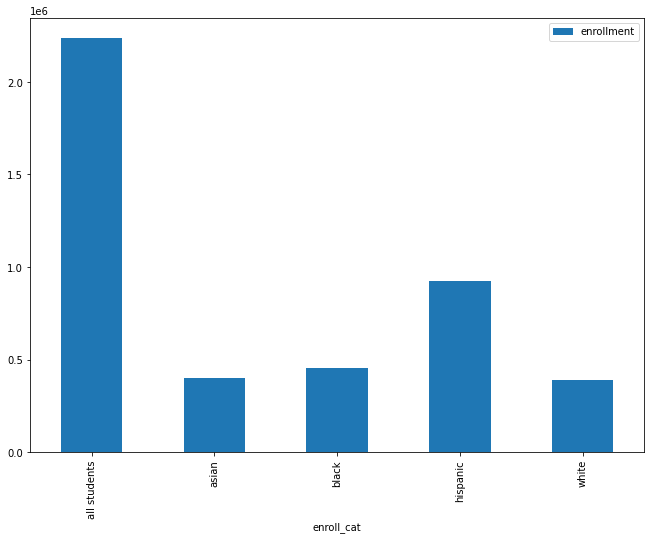

In [11]:
# create a bar chart
# the size is set in inches (don't think it's pixels or else it takes a long time to run)
# to see the full size image, right click and view image
plt.figure(figsize=(11,8))

y = ["enrollment"]
x = ["enroll_cat"]
# districts = df[x + y].groupby("district", as_index=False).agg("sum")
# districts = df[x + y].agg("sum")
city_enroll.plot(x=x[0], y=y, kind="bar", figsize=(11, 8))

In [16]:
# run different OLS regression using the school demographics to predict mean_scale_score for all students
# the above example uses the R-like formual method for OLS
# this uses the python/programmatic approach

# calculate coefficients for these factors
factors = ['total_enrollment', 'asian_pct',  'black_pct', 
       'hispanic_pct',  'white_pct','swd_pct',  'ell_pct',  'poverty_pct']

# only use the All Students data as the dependent variable
data = df[df["category"]=="All Students"].copy()
y = data['mean_scale_score']

X = data[factors]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# pull out the coefficient values from the model
coeff = model.conf_int()
pd.DataFrame({"parameters": list(coeff.index), "coefficient":model.params})

coef_df = pd.DataFrame({
    'parameter': model.params.index.values[1:],
    'coef': model.params.values[1:],
    'pvalue': model.pvalues.round(4).values[1:]
})


coef_df


,parameter,coef,pvalue
0,total_enrollment,-0.016480,0.0000
1,asian_pct,-402.312304,0.0000
2,black_pct,-494.879826,0.0000
3,hispanic_pct,-445.087888,0.0000
4,white_pct,-410.701471,0.0000
5,swd_pct,65.215426,0.0011
6,ell_pct,-98.511141,0.0000
7,poverty_pct,56.568158,0.0000


In [21]:

# score = "mean_scale_score"
# G = nx.Graph()
# dv = ["mean_scale_score" for _ in range(len(coef_df))]
# colors = [{"color": "blue"} if x > 0 else {"color": "red"} for x in coef_df.coef]
# weights = [{"weight": math.ceil(weight)} for weight in coef_df.area_size]
# edges = zip(coef_df.parameter, dv, coef_df.coef)
# edges = tuple(edges)


# G.add_weighted_edges_from(edges)

# subax1 = plt.subplot(121)
# nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_color='r', edge_color='b')
# plt.show()  

# G = nx.Graph()
# edges = coef_df.copy()
# d = dict(zip(edges.columns,[score,0,0,500,score,"green"]))
